# Section 3 : Do-calculus 


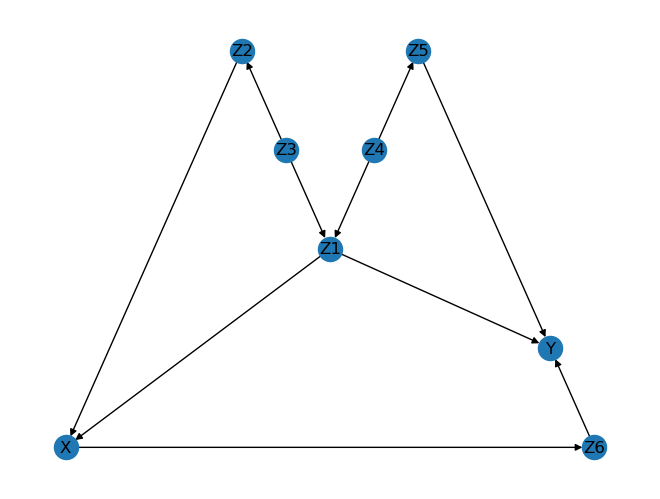

In [41]:
import networkx as nx

G = nx.DiGraph([
    ("X", "Z6"),
    ("Z6", "Y"),
    ("Z2", "X"),
    ("Z1", "Y"),
    ("Z5", "Y"),
    ("Z3", "Z2"),
    ("Z3", "Z1"),
    ("Z1", "X"),
    ("Z4", "Z1"),
    ("Z4", "Z5"),
])
nx.draw_planar(G, with_labels=True)

In [39]:
from itertools import combinations

def get_all_triplet(G):
    all_combinaison = []
    for n in list(G.nodes):
        possible_combinaison = list(G.successors(n)) + list(G.predecessors(n))
        all_combinaison += list([(c[0], n, c[1]) for c in combinations(possible_combinaison, 2)])
    return all_combinaison

def pattern_type(G:nx.DiGraph, triplet:list):
    n_left, n_central, n_right = triplet
    successors, predecessors = list(G.successors(n_central)), list(G.predecessors(n_central))
    is_left_predecessor = n_left in predecessors
    is_left_successor = n_left in successors
    is_right_successor = n_right in successors
    is_right_predecessors = n_right in predecessors
    if is_right_predecessors and is_left_predecessor:
        return "collider"
    elif is_left_successor and is_right_successor:
        return "fork"
    else:
        return "chain"

In [44]:
def sort_pattern_triplet(G):
    return {
        triplet:pattern_type(G=G, triplet=triplet)
        for triplet in get_all_triplet(G=G)
    }

sort_pattern_triplet(G)

{('Z6', 'X', 'Z2'): 'chain',
 ('Z6', 'X', 'Z1'): 'chain',
 ('Z2', 'X', 'Z1'): 'collider',
 ('Y', 'Z6', 'X'): 'chain',
 ('Z6', 'Y', 'Z1'): 'collider',
 ('Z6', 'Y', 'Z5'): 'collider',
 ('Z1', 'Y', 'Z5'): 'collider',
 ('X', 'Z2', 'Z3'): 'chain',
 ('Y', 'Z1', 'X'): 'fork',
 ('Y', 'Z1', 'Z3'): 'chain',
 ('Y', 'Z1', 'Z4'): 'chain',
 ('X', 'Z1', 'Z3'): 'chain',
 ('X', 'Z1', 'Z4'): 'chain',
 ('Z3', 'Z1', 'Z4'): 'collider',
 ('Y', 'Z5', 'Z4'): 'chain',
 ('Z2', 'Z3', 'Z1'): 'fork',
 ('Z1', 'Z4', 'Z5'): 'fork'}

[['X', 'Z6', 'Y'], ['X', 'Z2', 'Z3', 'Z1', 'Y'], ['X', 'Z2', 'Z3', 'Z1', 'Z4', 'Z5', 'Y'], ['X', 'Z1', 'Y'], ['X', 'Z1', 'Z4', 'Z5', 'Y']]


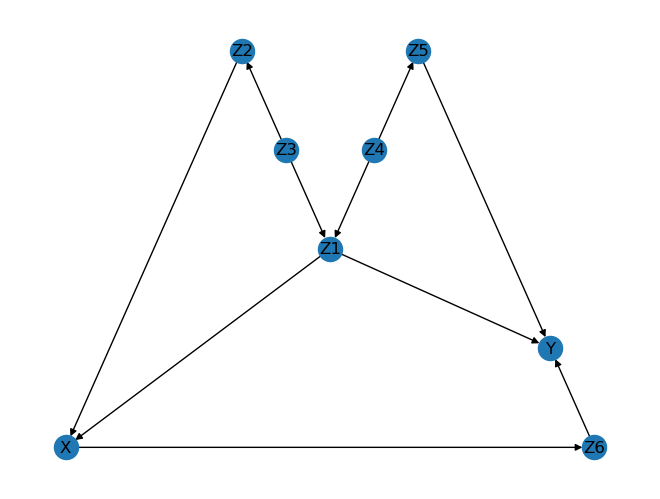

In [50]:
print(list(nx.all_simple_paths(G=G.to_undirected(), source="X", target="Y")))
nx.draw_planar(G, with_labels=True)

## Calcul numérique

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
normal_law = lambda: pd.Series(np.random.normal(size=10000))

e_x = normal_law()
e_y = normal_law()
e_z = normal_law()

z = 1*(e_z > 0)
x = 1*(z + e_x > 0.5)
y = 1*(z + x + e_y > 2)

In [3]:
# Exemple d'intervention: où tous les x ~> x = 1, on force les x à 1

y_dox = 1*(1 + z + e_y > 2)

In [5]:
df = pd.concat([x, y, z, y_dox], axis=1)
df.columns = ["x", "y", "z", "y_dox"]

In [9]:
print("soit P(y|do(x=1)) :", round(y_dox.mean(), 3))
print("soit P(y|x=1) :", round(y[x==1].mean(), 3))

soit P(y|do(x=1)) : 0.324
soit P(y|x=1) : 0.391


In [17]:

print("Soit la formule d'ajustement: P(y|do(x=1)) = P(y|x=1, z=1) * P(z=1) + P(y|x=1,z=0) * P(z=0)")
y[(x==1) & (z==1)].mean() * (z==1).mean() + y[(x==1) & (z==0)].mean()*(z==0).mean()

Soit la formule d'ajustement: P(y|do(x=1)) = P(y|x=1, z=1) * P(z=1) + P(y|x=1,z=0) * P(z=0)


0.3263932197005368

> Calcul des poids de probabilité inverse

$$ P(Y=y| do(X=x)) = \sum_z \frac{P(Y=y,X=x,Z=z) }{P(X=x|Z=z)}  $$

Avec $ P(X=x|Z=z) $ qui est le poids de distributions joints

In [41]:
print("Les moyennes par groupes:", df.groupby("z")["x"].mean())
print()
df["weight"] = df.groupby("z")["x"].transform("mean")
print("La redistribution des moyenne en fonction de l'appartenance des groupes Z:\n", df["weight"].head(5))
# |-> P(X = x| Z = z) par z groupe différents
# Soit en python: groupby('z').transform('mean') applique la moyenne au groupe défini par z
# et la restitue à tous les membres du groupe
# Appele score de propension (la )propensity score)

Les moyennes par groupes: z
0    0.304374
1    0.690789
Name: x, dtype: float64

La redistribution des moyenne en fonction de l'appartenance des groupes Z:
 0    0.304374
1    0.304374
2    0.690789
3    0.690789
4    0.304374
Name: weight, dtype: float64


In [38]:
y_weighted = y / df["weight"]
# Trie grace au y=0 et y=1

# La formule IPW peut s'écrire aussi comme cela:
# sum_n * Y * 1 * (x==1) / (weight * n) ?
sum(y_weighted[x==1])/y.size

0.3263932197005321

## Test avec le package dowhy en python


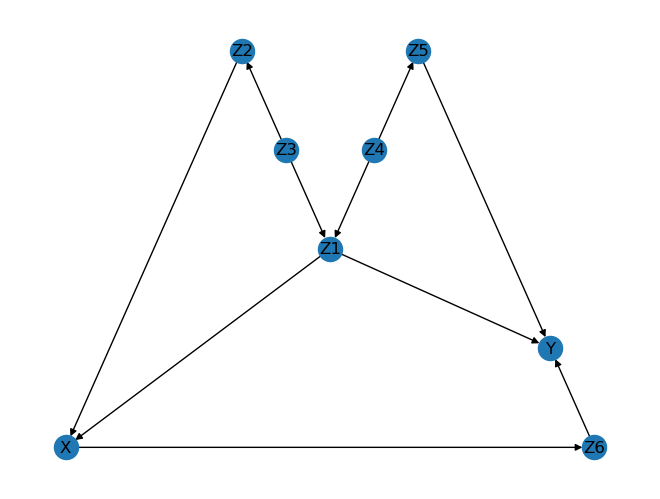

In [109]:
import networkx as nx

G = nx.DiGraph([
    ("X", "Z6"),
    ("Z6", "Y"),
    ("Z2", "X"),
    ("Z1", "Y"),
    ("Z5", "Y"),
    ("Z3", "Z2"),
    ("Z3", "Z1"),
    ("Z1", "X"),
    ("Z4", "Z1"),
    ("Z4", "Z5"),
])

n = 10000
# Générer les variables exogènes (erreurs) pour chaque nœud
e = {node: np.random.normal(size=n) for node in G.nodes}

# Générer les données en suivant la structure causale
Z3 = (e["Z3"] > 0).astype(int)
Z4 = (e["Z4"] > -0.5).astype(int)
Z2 = (Z3 + e["Z2"] > 0.5).astype(int)
Z1 = (Z3 + Z4 + e["Z1"] > 1).astype(int)
Z5 = (Z4 + e["Z5"] > 0.5).astype(int)
X = (Z1 + Z2 + e["X"] > 1.5).astype(int)
Z6 = (X + e["Z6"] > 0.5).astype(int)
Y = (Z1 + Z5 + Z6 + e["Y"] > 2).astype(int)

# Créer un DataFrame avec les données générées
df = pd.DataFrame({
    "X": X,
    "Z1": Z1,
    "Z2": Z2,
    "Z3": Z3,
    "Z4": Z4,
    "Z5": Z5,
    "Z6": Z6,
    "Y": Y,
})

nx.draw_planar(G, with_labels=True)

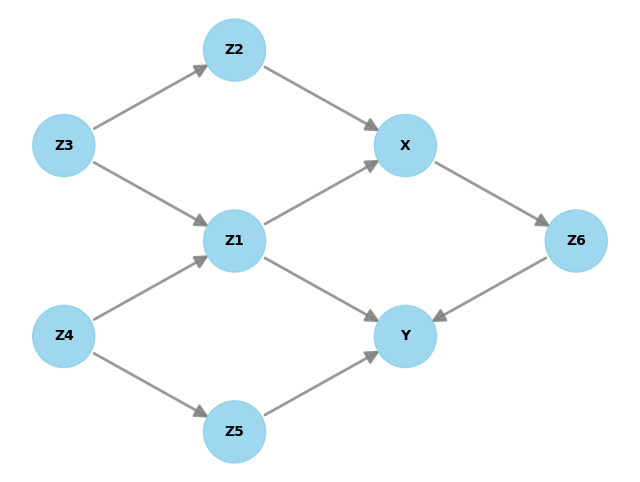

In [110]:
from dowhy import CausalModel

model = CausalModel(
    data=df, 
    treatment="X",
    outcome="Y",
    graph=G
)
model.view_model()

In [115]:
from dowhy import EstimandType


identified_estimand = model.identify_effect(
    method_name="maximal-adjustment"
)

print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                       
────(E[Y|Z5,Z3,Z1,Z4,Z2])
d[X]                     
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z5,Z3,Z1,Z4,Z2,U) = P(Y|X,Z5,Z3,Z1,Z4,Z2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡  d       d        ⎤
E⎢─────(Y)⋅────([Z₆])⎥
 ⎣d[Z₆]    d[X]      ⎦
Estimand assumption 1, Full-mediation: Z6 intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z6} then P(Z6|X,U) = P(Z6|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z6} and U→Y then P(Y|Z6, X, U) = P(Y|Z6, X)



---

> Formule de l'ajustement BD de X à Y
$$ 

    \sum_{z4,z3,z5,z6,z1}P(y|z4,z3,z5,z1,z2,x,z6)P(z6|z4,z3,z1,z2,x)P(z1|z4,z3)P(z5|z4)P(z3)P(z4)
$$

formule de base:

$$
 
 P(Y = y|do(X=x)) = \sum_z P(Y = y| X=x, Z=z)P(Z=z)

$$


Si on déclare z1 comme non observer on passe par le chemin x -> z6 -> Y on obtient la formule suivante:

> Formule de l'ajustement FD de X à Y
$$ 

    \sum_{z4,z5,z6}P(y|z4,z3,z5,z2,x,z6)P(z6|z3,z2,x)P(z5|z4)P(z4)
$$

formule de base:

$$

P(Y=y|do(X=x)) = \sum_z \sum_{x'} P(Y=y|Z=z,X=x')P(X=x')P(Z=z|X=x)

$$


## Exemple d'echec

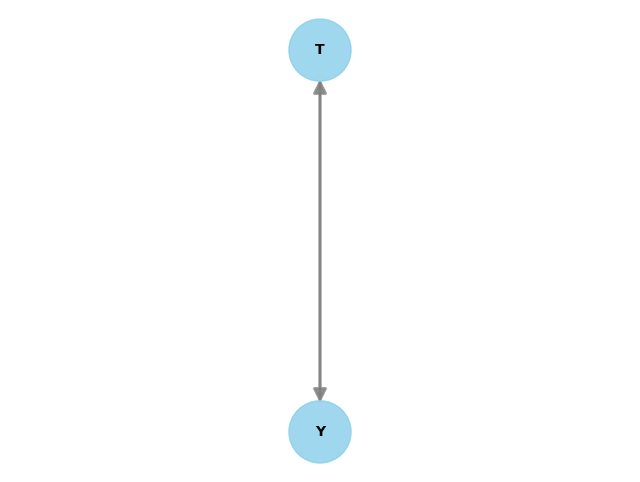

Not a dag !


In [123]:
# Random data
treatment = "T"
outcome = "Y"
causal_graph = "digraph{T->Y; Y->T;}"
columns = list(treatment) + list(outcome)
df = pd.DataFrame(columns=columns)

# Causal Model Initialization
causal_model = CausalModel(df, treatment, outcome, graph=causal_graph)

# View graph
causal_model.view_model()
try:
    identified_estimand = causal_model.identify_effect(method_name="id-algorithm")
except:
    print("Not a dag !")

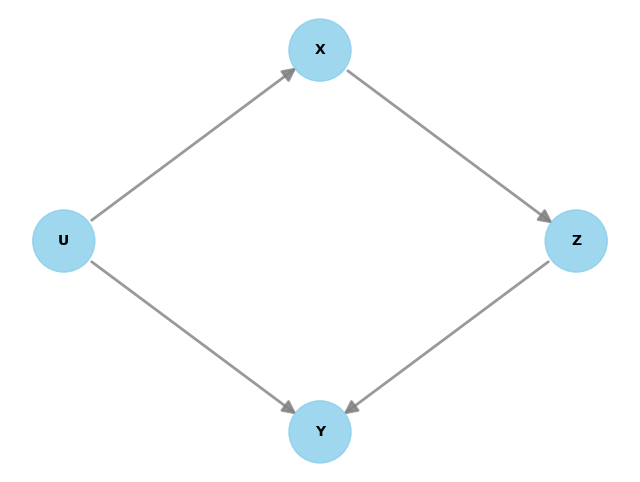

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,U,U) = P(Y|X,U)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [136]:
from dowhy import CausalModel
import pandas as pd
import numpy as np

# Générer les données observées
n = 10000
e = {node: np.random.normal(size=n) for node in [
    "X", "Y"
]}
X = ( e["X"] > 1.5).astype(int)
Y = (X + e["Y"] > 2).astype(int)

df = pd.DataFrame(columns=["X", "Y", "U", "Z"])

# Définir le graphe causal avec un facteur non observé
causal_graph = """
digraph {
    U -> X;
    U -> Y;
    X -> Z;
    Z -> Y;
}
"""

# Créer un modèle causal
model = CausalModel(
    data=df,
    treatment="X",
    outcome="Y",
    graph=causal_graph
)

# Visualiser le graphe causal
model.view_model()

# Identifier et estimer l'effet causal
identified_estimand = model.identify_effect()
print(identified_estimand)


## Avec des données non observées

In [137]:
e_x = np.random.normal(10000)
e_y = np.random.normal(10000)
e_z = np.random.normal(10000)
u = np.random.normal(10000)

# Create nodes for the DAG: y = z, z = x, y =-> x  
x = 1*(e_x + u > 0)
z = 1*(x + e_z > 0.5)
y = 1*(z + e_y + u > 0.5)

z_dox = 1*(1 + e_z > 0.5)
y_dox = 1*(z_dox + e_y + u > 0.5)

df = pd.DataFrame({"x":x, "y":y, "z":z, "z_dox":z_dox, "y_dox":y_dox})

# P(y|do(x=1))
np.mean(y_dox)
# P(y|x=1)
np.mean(y[x==1])
# Frontdoor adjustment formula
np.mean(y[x==1 & z==1]) * np.mean(x==1) * np.mean(z[x==1]==1) +\
   np.mean(y[x==0 & z==1]) * np.mean(x==0) * np.mean(z[x==1]==1) +\
   np.mean(y[x==1 & z==0]) * np.mean(x==1) * np.mean(z[x==1]==0) +\
   np.mean(y[x==0 & z==0]) * np.mean(x==0) * np.mean(z[x==1]==0)

ValueError: If using all scalar values, you must pass an index